# Training machine learning model for cellulose solubility in ionic liquids prediction

In [1]:
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from rdkit.Chem import Descriptors
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import shap

2024-11-21 14:53:15.115391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 14:53:16.054686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Training models on total dataset

1. Read dataset

In [2]:
df = pd.read_csv('dataset_for_cellulose_solubility_ML_model.csv')
smis = list(df.loc[:, 'smiles'])
cation = list(df.loc[:, 'cation'])
anion = list(df.loc[:, 'anion'])
Ts = list(df.loc[:, 'T'])
Crystal = list(df.loc[:, 'cellulose_crystal'])
Crystal_avicel = []
Crystal_MCC = []
Crystal_cellulose = []
for item in Crystal:
    if item == 'Avicel':
        Crystal_avicel.append(1)
        Crystal_MCC.append(0)
        Crystal_cellulose.append(0)
    
    elif item == 'MCC':
        Crystal_avicel.append(0)
        Crystal_MCC.append(1)
        Crystal_cellulose.append(0)
        
    elif item == 'cellulose':
        Crystal_avicel.append(0)
        Crystal_MCC.append(0)
        Crystal_cellulose.append(1)
        
heating_time = list(df.loc[:,'heating_time'])
Ys = list(df.loc[:, 'solv'])

2. Calculate descriptors

In [3]:
def getMolDescriptors(smi):
    mol = Chem.MolFromSmiles(smi)
    res = []
    for nm, fn in Descriptors._descList:
        res.append(fn(mol))
    return res
def smiles_to_MACCS(smi): 
    mol = Chem.MolFromSmiles(smi)
    fp = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.array(fp, float)
    return fp
Des_cation = np.array([getMolDescriptors(c) for c in cation])
Des_anion = np.array([getMolDescriptors(a) for a in anion])
fp_anion = np.array([smiles_to_MACCS(a) for a in anion])
fp_cation = np.array([smiles_to_MACCS(c) for c in cation])
fp_mol = np.array([smiles_to_MACCS(s) for s in smis])
X = np.c_[fp_cation, Des_cation, fp_anion, Des_anion, Ts, heating_time, Crystal_avicel, Crystal_MCC, Crystal_cellulose]
Y = np.array(Ys).reshape(len(Ys), 1)

3. Split traning set and testing set

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

4. Random forest (RF) regression

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


R^2_test=0.664013
mse_test=17.359073


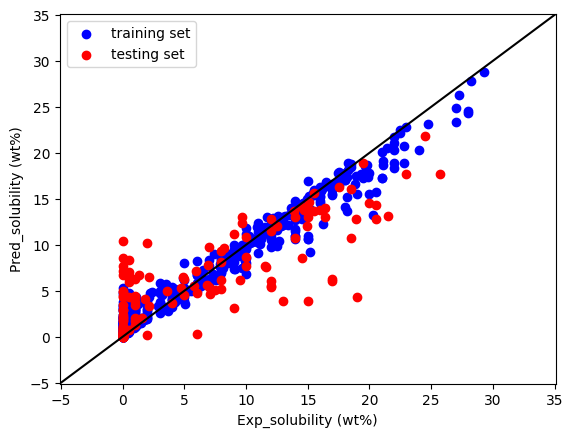

In [5]:
regr = RandomForestRegressor(random_state=1)
regr.fit(X_train, Y_train)
Y_test_pred = regr.predict(X_test)
Y_train_pred = regr.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
r2_train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
plt.figure()
plt.xlabel("Exp_solubility (wt%)")
plt.ylabel("Pred_solubility (wt%)")
plt.plot([-5.1, 35.1], [-5.1, 35.1], c='black')
plt.scatter(Y_train, Y_train_pred, c='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, c='red', label='testing set')
plt.xlim([-5.1, 35.1])
plt.ylim([-5.1, 35.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('mse_test=%f'%mse_test)

5. Extreme gradient boosting (XGBoost) regression

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


R^2_test=0.583975
mse_test=21.494321


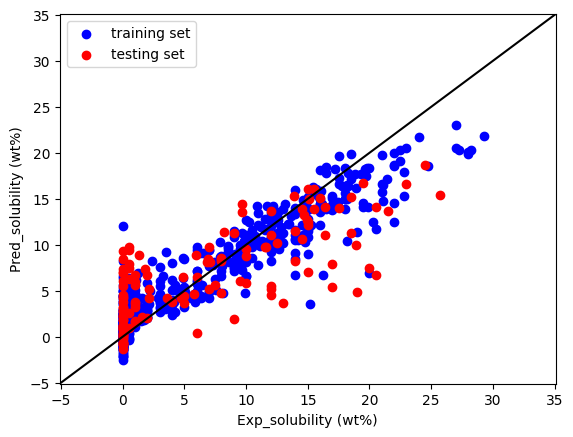

In [6]:
regr = GradientBoostingRegressor(random_state=1)
regr.fit(X_train, Y_train)
Y_test_pred = regr.predict(X_test)
Y_train_pred = regr.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
r2_train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
plt.figure()
plt.xlabel("Exp_solubility (wt%)")
plt.ylabel("Pred_solubility (wt%)")
plt.plot([-5.1, 35.1], [-5.1, 35.1], c='black')
plt.scatter(Y_train, Y_train_pred, c='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, c='red', label='testing set')
plt.xlim([-5.1, 35.1])
plt.ylim([-5.1, 35.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('mse_test=%f'%mse_test)

6. Ridge regression

R^2_test=0.396665
mse_test=31.171868


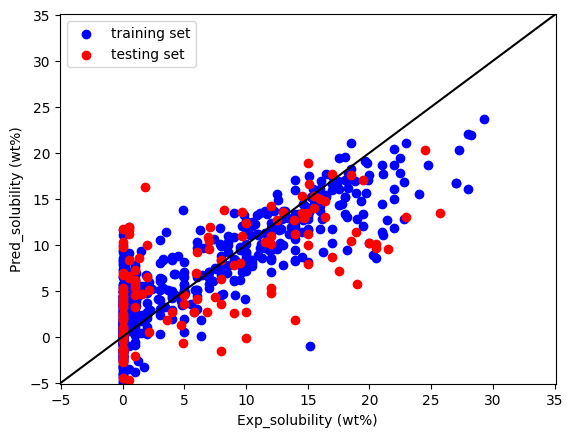

In [7]:
regr = Ridge(random_state=1)
regr.fit(X_train, Y_train)
Y_test_pred = regr.predict(X_test)
Y_train_pred = regr.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
r2_train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
plt.figure()
plt.xlabel("Exp_solubility (wt%)")
plt.ylabel("Pred_solubility (wt%)")
plt.plot([-5.1, 35.1], [-5.1, 35.1], c='black')
plt.scatter(Y_train, Y_train_pred, c='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, c='red', label='testing set')
plt.xlim([-5.1, 35.1])
plt.ylim([-5.1, 35.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('mse_test=%f'%mse_test)

7. Artificial neural network (ANN) model

In [8]:
keras.utils.set_random_seed(1)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=759, input_shape=(None, 759), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=759, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=1))
model.compile(loss='MSE', optimizer=tf.keras.optimizers.Adam(0.0001))
model.fit(X_train, Y_train, epochs=7000)

Epoch 1/7000


2024-11-21 14:54:51.036000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-21 14:54:51.041599: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


17/17 [==============================] - 1s 6ms/step - loss: 9794752.0000
Epoch 2/7000
17/17 [==============================] - 0s 5ms/step - loss: 29119788.0000
Epoch 3/7000
17/17 [==============================] - 0s 4ms/step - loss: 566709440.0000
Epoch 4/7000
17/17 [==============================] - 0s 5ms/step - loss: 97841528.0000
Epoch 5/7000
17/17 [==============================] - 0s 4ms/step - loss: 453182432.0000
Epoch 6/7000
17/17 [==============================] - 0s 5ms/step - loss: 5160670.5000
Epoch 7/7000
17/17 [==============================] - 0s 4ms/step - loss: 171483648.0000
Epoch 8/7000
17/17 [==============================] - 0s 4ms/step - loss: 494710592.0000
Epoch 9/7000
17/17 [==============================] - 0s 4ms/step - loss: 276311840.0000
Epoch 10/7000
17/17 [==============================] - 0s 4ms/step - loss: 253785760.0000
Epoch 11/7000
17/17 [==============================] - 0s 4ms/step - loss: 817068352.0000
Epoch 12/7000
17/17 [=================

17/17 [==============================] - 0s 1ms/step
R^2_test=0.564002
mse_test=22.526243


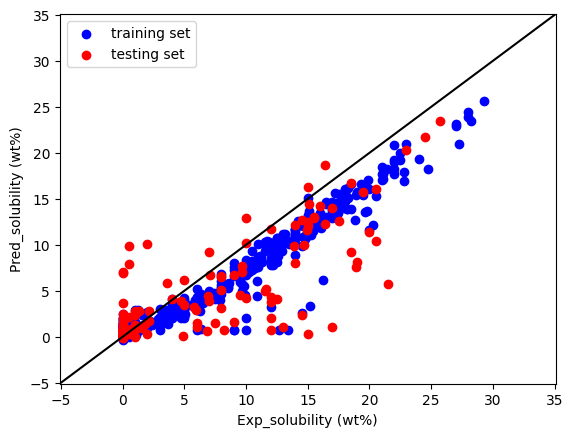

In [9]:
Y_test_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
r2_train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
plt.figure()
plt.xlabel("Exp_solubility (wt%)")
plt.ylabel("Pred_solubility (wt%)")
plt.plot([-5.1, 35.1], [-5.1, 35.1], c='black')
plt.scatter(Y_train, Y_train_pred, c='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, c='red', label='testing set')
plt.xlim([-5.1, 35.1])
plt.ylim([-5.1, 35.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('mse_test=%f'%mse_test)

## Training models on data points with water content less than 1%

1. Read dataset

In [10]:
df = pd.read_csv('dataset_for_cellulose_solubility_ML_model_water_content_less_1%.csv')
smis = list(df.loc[:, 'smiles'])
cation = list(df.loc[:, 'cation'])
anion = list(df.loc[:, 'anion'])
Ts = list(df.loc[:, 'T'])
Crystal = list(df.loc[:, 'cellulose_crystal'])
Crystal_avicel = []
Crystal_MCC = []
Crystal_cellulose = []
for item in Crystal:
    if item == 'Avicel':
        Crystal_avicel.append(1)
        Crystal_MCC.append(0)
        Crystal_cellulose.append(0)
    
    elif item == 'MCC':
        Crystal_avicel.append(0)
        Crystal_MCC.append(1)
        Crystal_cellulose.append(0)
        
    elif item == 'cellulose':
        Crystal_avicel.append(0)
        Crystal_MCC.append(0)
        Crystal_cellulose.append(1)
        
heating_time = list(df.loc[:,'heating_time'])
Ys = list(df.loc[:, 'solv'])

2. Calculate descriptors

In [11]:
def getMolDescriptors(smi):
    mol = Chem.MolFromSmiles(smi)
    res = []
    for nm, fn in Descriptors._descList:
        res.append(fn(mol))
    return res
def smiles_to_MACCS(smi): 
    mol = Chem.MolFromSmiles(smi)
    fp = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.array(fp, float)
    return fp
Des_cation = np.array([getMolDescriptors(c) for c in cation])
Des_anion = np.array([getMolDescriptors(a) for a in anion])
fp_anion = np.array([smiles_to_MACCS(a) for a in anion])
fp_cation = np.array([smiles_to_MACCS(c) for c in cation])
fp_mol = np.array([smiles_to_MACCS(s) for s in smis])
X = np.c_[fp_cation, Des_cation, fp_anion, Des_anion, Ts, heating_time, Crystal_avicel, Crystal_MCC, Crystal_cellulose]
Y = np.array(Ys).reshape(len(Ys), 1)

3. Split traning set and testing set

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

4. Random forest (RF) regression

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


R^2_test=0.864433
mse_test=8.970935


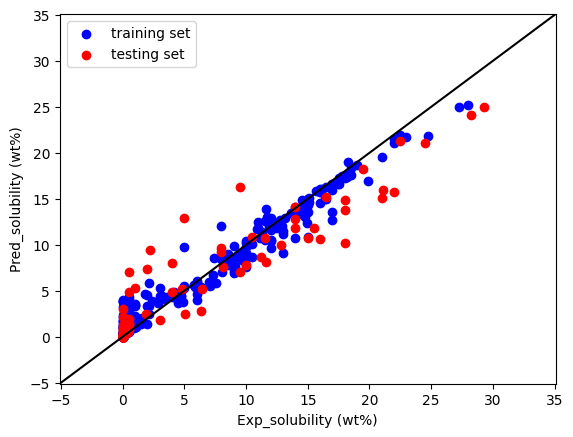

In [13]:
regr = RandomForestRegressor(random_state=1)
regr.fit(X_train, Y_train)
Y_test_pred = regr.predict(X_test)
Y_train_pred = regr.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
r2_train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
plt.figure()
plt.xlabel("Exp_solubility (wt%)")
plt.ylabel("Pred_solubility (wt%)")
plt.plot([-5.1, 35.1], [-5.1, 35.1], c='black')
plt.scatter(Y_train, Y_train_pred, c='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, c='red', label='testing set')
plt.xlim([-5.1, 35.1])
plt.ylim([-5.1, 35.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('mse_test=%f'%mse_test)

5. Extreme gradient boosting (XGBoost) regression

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


R^2_test=0.850375
mse_test=9.901146


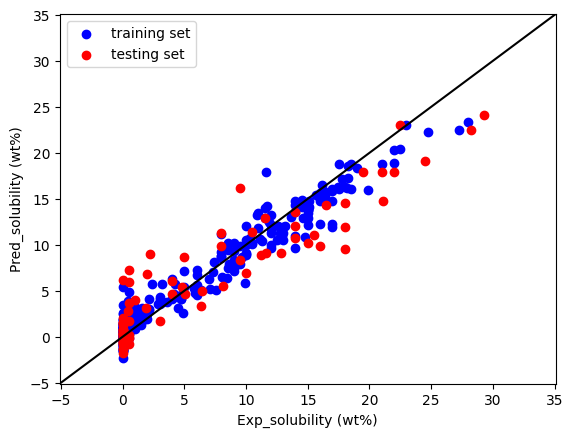

In [14]:
regr = GradientBoostingRegressor(random_state=1)
regr.fit(X_train, Y_train)
Y_test_pred = regr.predict(X_test)
Y_train_pred = regr.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
r2_train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
plt.figure()
plt.xlabel("Exp_solubility (wt%)")
plt.ylabel("Pred_solubility (wt%)")
plt.plot([-5.1, 35.1], [-5.1, 35.1], c='black')
plt.scatter(Y_train, Y_train_pred, c='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, c='red', label='testing set')
plt.xlim([-5.1, 35.1])
plt.ylim([-5.1, 35.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('mse_test=%f'%mse_test)

6. Ridge regression

R^2_test=0.659019
mse_test=22.563815


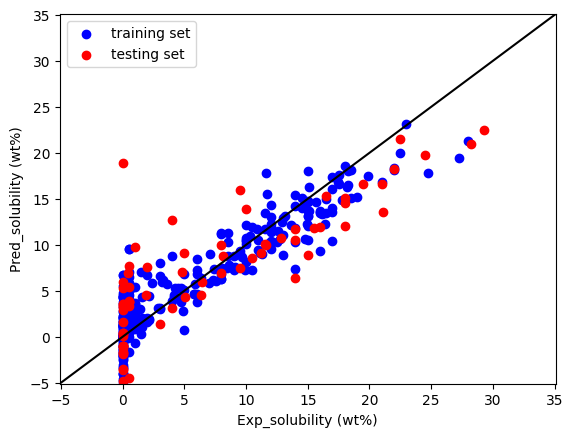

In [15]:
regr = Ridge(random_state=1)
regr.fit(X_train, Y_train)
Y_test_pred = regr.predict(X_test)
Y_train_pred = regr.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
r2_train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
plt.figure()
plt.xlabel("Exp_solubility (wt%)")
plt.ylabel("Pred_solubility (wt%)")
plt.plot([-5.1, 35.1], [-5.1, 35.1], c='black')
plt.scatter(Y_train, Y_train_pred, c='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, c='red', label='testing set')
plt.xlim([-5.1, 35.1])
plt.ylim([-5.1, 35.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('mse_test=%f'%mse_test)

7. Artificial neural network (ANN) model

In [16]:
keras.utils.set_random_seed(1)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=759, input_shape=(None, 759), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=759, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=1))
model.compile(loss='MSE', optimizer=tf.keras.optimizers.Adam(0.0001))
model.fit(X_train, Y_train, epochs=7000)

Epoch 1/7000
10/10 [==============================] - 0s 6ms/step - loss: 146463456.0000
Epoch 2/7000
10/10 [==============================] - 0s 4ms/step - loss: 521418848.0000
Epoch 3/7000
10/10 [==============================] - 0s 5ms/step - loss: 7054614528.0000
Epoch 4/7000
10/10 [==============================] - 0s 5ms/step - loss: 664111360.0000
Epoch 5/7000
10/10 [==============================] - 0s 4ms/step - loss: 3006166016.0000
Epoch 6/7000
10/10 [==============================] - 0s 5ms/step - loss: 1034763456.0000
Epoch 7/7000
10/10 [==============================] - 0s 5ms/step - loss: 961562240.0000
Epoch 8/7000
10/10 [==============================] - 0s 4ms/step - loss: 1691671424.0000
Epoch 9/7000
10/10 [==============================] - 0s 4ms/step - loss: 963263168.0000
Epoch 10/7000
10/10 [==============================] - 0s 5ms/step - loss: 7707523072.0000
Epoch 11/7000
10/10 [==============================] - 0s 4ms/step - loss: 317356384.0000
Epoch 12/7000


10/10 [==============================] - 0s 1ms/step
R^2_test=0.874130
mse_test=8.329200


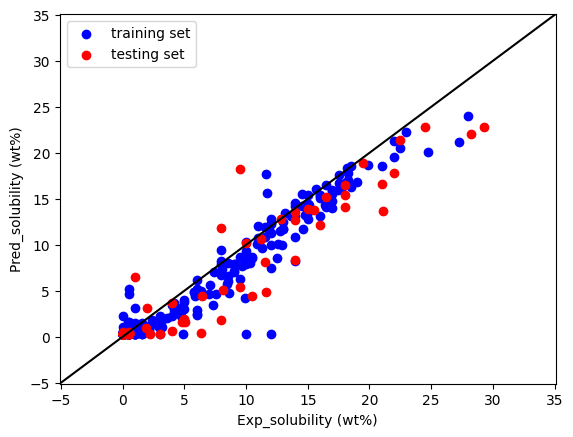

In [17]:
Y_test_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
r2_train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
plt.figure()
plt.xlabel("Exp_solubility (wt%)")
plt.ylabel("Pred_solubility (wt%)")
plt.plot([-5.1, 35.1], [-5.1, 35.1], c='black')
plt.scatter(Y_train, Y_train_pred, c='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, c='red', label='testing set')
plt.xlim([-5.1, 35.1])
plt.ylim([-5.1, 35.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('mse_test=%f'%mse_test)

Interpret model using SHAP

In [18]:
explainer = shap.Explainer(model.predict, X_train, seed=1)
shap_values = explainer(X_test, max_evals=2000)

758/758 [==============================] - 1s 931us/step


PermutationExplainer explainer:   3%|▎         | 2/76 [00:00<?, ?it/s]

862/862 [==============================] - 1s 868us/step


PermutationExplainer explainer:   5%|▌         | 4/76 [00:15<02:37,  2.19s/it]

884/884 [==============================] - 1s 932us/step


PermutationExplainer explainer:   7%|▋         | 5/76 [00:20<03:48,  3.22s/it]

978/978 [==============================] - 1s 894us/step


PermutationExplainer explainer:   8%|▊         | 6/76 [00:25<04:30,  3.87s/it]

890/890 [==============================] - 1s 931us/step


PermutationExplainer explainer:   9%|▉         | 7/76 [00:29<04:43,  4.11s/it]

730/730 [==============================] - 1s 875us/step


PermutationExplainer explainer:  11%|█         | 8/76 [00:33<04:30,  3.97s/it]

740/740 [==============================] - 1s 877us/step


PermutationExplainer explainer:  12%|█▏        | 9/76 [00:37<04:23,  3.94s/it]

719/719 [==============================] - 1s 921us/step


PermutationExplainer explainer:  13%|█▎        | 10/76 [00:40<04:16,  3.88s/it]

751/751 [==============================] - 1s 894us/step


PermutationExplainer explainer:  14%|█▍        | 11/76 [00:44<04:13,  3.89s/it]

861/861 [==============================] - 1s 899us/step


PermutationExplainer explainer:  16%|█▌        | 12/76 [00:49<04:18,  4.04s/it]

872/872 [==============================] - 1s 876us/step


PermutationExplainer explainer:  17%|█▋        | 13/76 [00:53<04:22,  4.16s/it]

974/974 [==============================] - 1s 891us/step


PermutationExplainer explainer:  18%|█▊        | 14/76 [00:58<04:32,  4.40s/it]

958/958 [==============================] - 1s 905us/step


PermutationExplainer explainer:  20%|█▉        | 15/76 [01:03<04:36,  4.53s/it]

793/793 [==============================] - 1s 936us/step


PermutationExplainer explainer:  21%|██        | 16/76 [01:07<04:22,  4.38s/it]

947/947 [==============================] - 1s 909us/step


PermutationExplainer explainer:  22%|██▏       | 17/76 [01:12<04:27,  4.53s/it]

797/797 [==============================] - 1s 876us/step


PermutationExplainer explainer:  24%|██▎       | 18/76 [01:16<04:13,  4.36s/it]

895/895 [==============================] - 1s 890us/step


PermutationExplainer explainer:  25%|██▌       | 19/76 [01:21<04:19,  4.55s/it]

892/892 [==============================] - 1s 935us/step


PermutationExplainer explainer:  26%|██▋       | 20/76 [01:25<04:16,  4.58s/it]

855/855 [==============================] - 1s 952us/step


PermutationExplainer explainer:  28%|██▊       | 21/76 [01:30<04:08,  4.52s/it]

713/713 [==============================] - 1s 925us/step


PermutationExplainer explainer:  29%|██▉       | 22/76 [01:34<03:50,  4.28s/it]

762/762 [==============================] - 1s 925us/step


PermutationExplainer explainer:  30%|███       | 23/76 [01:37<03:40,  4.16s/it]

931/931 [==============================] - 1s 879us/step


PermutationExplainer explainer:  32%|███▏      | 24/76 [01:42<03:44,  4.32s/it]

775/775 [==============================] - 1s 892us/step


PermutationExplainer explainer:  33%|███▎      | 25/76 [01:46<03:35,  4.23s/it]

1063/1063 [==============================] - 1s 966us/step


PermutationExplainer explainer:  34%|███▍      | 26/76 [01:52<03:52,  4.65s/it]

775/775 [==============================] - 1s 907us/step


PermutationExplainer explainer:  36%|███▌      | 27/76 [01:56<03:38,  4.45s/it]

732/732 [==============================] - 1s 916us/step


PermutationExplainer explainer:  37%|███▋      | 28/76 [02:00<03:25,  4.27s/it]

991/991 [==============================] - 1s 922us/step


PermutationExplainer explainer:  38%|███▊      | 29/76 [02:05<03:32,  4.53s/it]

788/788 [==============================] - 1s 932us/step


PermutationExplainer explainer:  39%|███▉      | 30/76 [02:09<03:22,  4.41s/it]

784/784 [==============================] - 1s 897us/step


PermutationExplainer explainer:  41%|████      | 31/76 [02:13<03:13,  4.30s/it]

736/736 [==============================] - 1s 917us/step


PermutationExplainer explainer:  42%|████▏     | 32/76 [02:17<03:01,  4.12s/it]

922/922 [==============================] - 1s 943us/step


PermutationExplainer explainer:  43%|████▎     | 33/76 [02:22<03:06,  4.35s/it]

978/978 [==============================] - 1s 948us/step


PermutationExplainer explainer:  45%|████▍     | 34/76 [02:27<03:11,  4.57s/it]

757/757 [==============================] - 1s 906us/step


PermutationExplainer explainer:  46%|████▌     | 35/76 [02:31<02:59,  4.38s/it]

762/762 [==============================] - 1s 947us/step


PermutationExplainer explainer:  47%|████▋     | 36/76 [02:34<02:49,  4.24s/it]

859/859 [==============================] - 1s 912us/step


PermutationExplainer explainer:  49%|████▊     | 37/76 [02:39<02:47,  4.30s/it]

714/714 [==============================] - 1s 952us/step


PermutationExplainer explainer:  50%|█████     | 38/76 [02:43<02:36,  4.12s/it]

877/877 [==============================] - 1s 900us/step


PermutationExplainer explainer:  51%|█████▏    | 39/76 [02:47<02:36,  4.24s/it]

1034/1034 [==============================] - 1s 889us/step


PermutationExplainer explainer:  53%|█████▎    | 40/76 [02:53<02:50,  4.72s/it]

1005/1005 [==============================] - 1s 906us/step


PermutationExplainer explainer:  54%|█████▍    | 41/76 [02:58<02:52,  4.92s/it]

775/775 [==============================] - 1s 872us/step


PermutationExplainer explainer:  55%|█████▌    | 42/76 [03:02<02:36,  4.61s/it]

1059/1059 [==============================] - 1s 853us/step


PermutationExplainer explainer:  57%|█████▋    | 43/76 [03:08<02:39,  4.83s/it]

785/785 [==============================] - 1s 903us/step


PermutationExplainer explainer:  58%|█████▊    | 44/76 [03:12<02:26,  4.59s/it]

775/775 [==============================] - 1s 898us/step


PermutationExplainer explainer:  59%|█████▉    | 45/76 [03:16<02:16,  4.39s/it]

849/849 [==============================] - 1s 939us/step


PermutationExplainer explainer:  61%|██████    | 46/76 [03:20<02:12,  4.42s/it]

806/806 [==============================] - 1s 928us/step


PermutationExplainer explainer:  62%|██████▏   | 47/76 [03:24<02:06,  4.35s/it]

743/743 [==============================] - 1s 921us/step


PermutationExplainer explainer:  63%|██████▎   | 48/76 [03:28<01:57,  4.20s/it]

834/834 [==============================] - 1s 879us/step


PermutationExplainer explainer:  64%|██████▍   | 49/76 [03:32<01:53,  4.20s/it]

855/855 [==============================] - 1s 924us/step


PermutationExplainer explainer:  66%|██████▌   | 50/76 [03:37<01:50,  4.24s/it]

1057/1057 [==============================] - 1s 906us/step


PermutationExplainer explainer:  67%|██████▋   | 51/76 [03:42<01:54,  4.59s/it]

1071/1071 [==============================] - 1s 890us/step


PermutationExplainer explainer:  68%|██████▊   | 52/76 [03:48<01:56,  4.87s/it]

792/792 [==============================] - 1s 920us/step


PermutationExplainer explainer:  70%|██████▉   | 53/76 [03:52<01:46,  4.65s/it]

698/698 [==============================] - 1s 892us/step


PermutationExplainer explainer:  71%|███████   | 54/76 [03:55<01:35,  4.36s/it]

781/781 [==============================] - 1s 961us/step


PermutationExplainer explainer:  72%|███████▏  | 55/76 [03:59<01:30,  4.29s/it]

826/826 [==============================] - 1s 867us/step


PermutationExplainer explainer:  74%|███████▎  | 56/76 [04:04<01:25,  4.30s/it]

943/943 [==============================] - 1s 889us/step


PermutationExplainer explainer:  75%|███████▌  | 57/76 [04:09<01:24,  4.44s/it]

713/713 [==============================] - 1s 852us/step


PermutationExplainer explainer:  76%|███████▋  | 58/76 [04:12<01:15,  4.17s/it]

919/919 [==============================] - 1s 891us/step


PermutationExplainer explainer:  78%|███████▊  | 59/76 [04:17<01:12,  4.27s/it]

753/753 [==============================] - 1s 908us/step


PermutationExplainer explainer:  79%|███████▉  | 60/76 [04:21<01:09,  4.31s/it]

989/989 [==============================] - 1s 911us/step


PermutationExplainer explainer:  80%|████████  | 61/76 [04:26<01:07,  4.53s/it]

1008/1008 [==============================] - 1s 875us/step


PermutationExplainer explainer:  82%|████████▏ | 62/76 [04:31<01:06,  4.75s/it]

808/808 [==============================] - 1s 908us/step


PermutationExplainer explainer:  83%|████████▎ | 63/76 [04:35<00:59,  4.55s/it]

957/957 [==============================] - 1s 927us/step


PermutationExplainer explainer:  84%|████████▍ | 64/76 [04:40<00:55,  4.66s/it]

839/839 [==============================] - 1s 906us/step


PermutationExplainer explainer:  86%|████████▌ | 65/76 [04:45<00:50,  4.55s/it]

786/786 [==============================] - 1s 908us/step


PermutationExplainer explainer:  87%|████████▋ | 66/76 [04:49<00:43,  4.39s/it]

807/807 [==============================] - 1s 924us/step


PermutationExplainer explainer:  88%|████████▊ | 67/76 [04:53<00:38,  4.32s/it]

792/792 [==============================] - 1s 998us/step


PermutationExplainer explainer:  89%|████████▉ | 68/76 [04:57<00:33,  4.24s/it]

1042/1042 [==============================] - 1s 949us/step


PermutationExplainer explainer:  91%|█████████ | 69/76 [05:02<00:32,  4.58s/it]

844/844 [==============================] - 1s 887us/step


PermutationExplainer explainer:  92%|█████████▏| 70/76 [05:06<00:26,  4.48s/it]

757/757 [==============================] - 1s 897us/step


PermutationExplainer explainer:  93%|█████████▎| 71/76 [05:10<00:21,  4.29s/it]

911/911 [==============================] - 1s 913us/step


PermutationExplainer explainer:  95%|█████████▍| 72/76 [05:15<00:17,  4.42s/it]

704/704 [==============================] - 1s 916us/step


PermutationExplainer explainer:  96%|█████████▌| 73/76 [05:19<00:12,  4.19s/it]

777/777 [==============================] - 1s 924us/step


PermutationExplainer explainer:  97%|█████████▋| 74/76 [05:23<00:08,  4.18s/it]

839/839 [==============================] - 1s 914us/step


PermutationExplainer explainer:  99%|█████████▊| 75/76 [05:27<00:04,  4.19s/it]

716/716 [==============================] - 1s 927us/step


PermutationExplainer explainer: 100%|██████████| 76/76 [05:31<00:00,  4.03s/it]

872/872 [==============================] - 1s 895us/step


PermutationExplainer explainer: 77it [05:35,  4.48s/it]                        


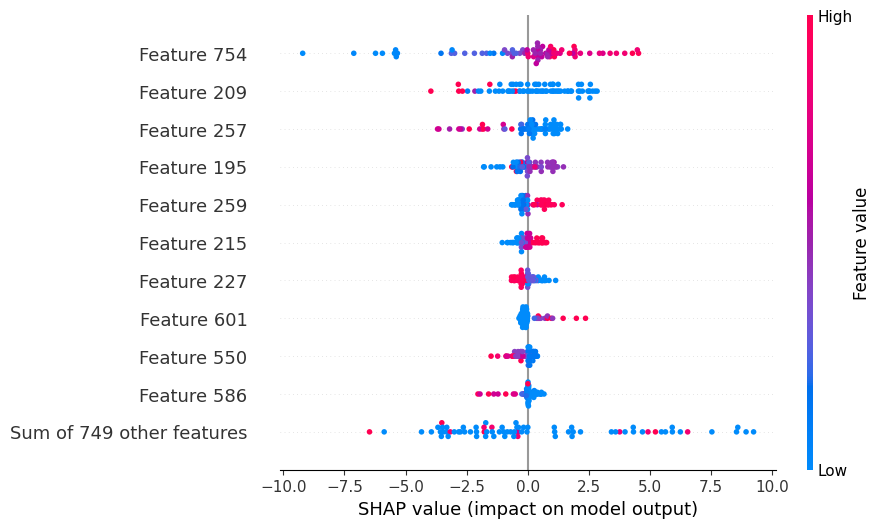

In [19]:
shap.plots.beeswarm(shap_values, max_display=11)

## Cross validation

1. Random forest (RF) regression

In [20]:
kf = KFold(n_splits=10)
pred = np.zeros(len(Y))
for train_index, test_index in kf.split(X, Y):
    regr = RandomForestRegressor(random_state=1)
    regr.fit(X[train_index], Y[train_index])
    pred[test_index] = regr.predict(X[test_index])

print("R2: ", r2_score(Y, pred))
print("MSE: ", mean_squared_error(Y, pred))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

R2:  0.7991438126168499
MSE:  10.084518966611874


2. Extreme gradient boosting (XGBoost) regression

In [21]:
kf = KFold(n_splits=10)
pred = np.zeros(len(Y))
for train_index, test_index in kf.split(X, Y):
    regr = GradientBoostingRegressor(random_state=1)
    regr.fit(X[train_index], Y[train_index])
    pred[test_index] = regr.predict(X[test_index])

print("R2: ", r2_score(Y, pred))
print("MSE: ", mean_squared_error(Y, pred))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

R2:  0.7908661550630048
MSE:  10.500120774494599


3. Ridge regression

In [22]:
kf = KFold(n_splits=10)
pred = np.zeros(len(Y)).reshape(-1, 1)
for train_index, test_index in kf.split(X, Y):
    regr = Ridge(random_state=1)
    regr.fit(X[train_index], Y[train_index])
    pred[test_index] = regr.predict(X[test_index])

print("R2: ", r2_score(Y, pred))
print("MSE: ", mean_squared_error(Y, pred))

R2:  0.6028661996556202
MSE:  19.939158429886266


4. Artificial neural network (ANN) models

Please run python script: cross_validation_for_ANN_model.py
```bash
python cross_validation_for_ANN_model.py
```

## Applicability  domain

In [23]:
def identify_domian(training_set, test_IL):
    """
    A function to identifiy whether a test ionic liquid of interest located in the applicabilty domain of the training set.
    training_set: the descriptors numpy array of training set
    test_IL: the descriptors numpy array of IL to be tested
    """
    X_average = np.mean(training_set, axis=0)
    segma = np.std(training_set, axis=0)
    for i in range(len(segma)):
        if segma[i] == 0:
            segma[i] = 1
    S_k = np.abs(test_IL - X_average) / segma 
    if S_k.max() <= 3:
        ans = S_k.max()
    if S_k.min() > 3:
        ans = S_k.min()
    if S_k.max() > 3 and S_k.min() <= 3:
        ans = S_k.mean() + 1.28 * S_k.std()
    return ans